In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import boxcox
from scipy.special import inv_boxcox

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
def correct_data(df):
    """
    Corrects the data by removing outliers and interpolating missing values.

    Parameters:
    - df: pandas DataFrame with at least two columns: 'timestamp' and 'load'.

    Returns:
    - df: corrected pandas DataFrame.
    """
    # Remove outliers
    df = df.copy()
    df['load_diff'] = df['load'].diff(periods=1)
    outlier_idx = df['load_diff'].abs().idxmax()
    df.loc[outlier_idx-2:outlier_idx+2, 'load'] = None
    df['load'] = df['load'].interpolate(method='linear')

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    df.index = df.index.round('5min')
    df = df.asfreq('5min')
    df = df.interpolate()

    return df


def transform_series(df, use_boxcox=True):
    """
    Applies Box-Cox (optional) and StandardScaler to the 'load' column.

    Parameters:
        df (pd.DataFrame): DataFrame containing a 'load' column.
        use_boxcox (bool): Whether to apply Box-Cox transform before scaling.

    Returns:
        Tuple[pd.DataFrame, dict]: Transformed DataFrame, and scalers dict with Box-Cox lambda and StandardScaler.
    """
    df = df.copy()
    scalers = {}

    series = df['load'].values
    scalers['load'] = {}

    if use_boxcox:
        series, lam = boxcox(series)
        scalers['load']['lambda'] = lam

    scaler = StandardScaler()
    df['load'] = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    scalers['load']['scaler'] = scaler

    return df, scalers

def apply_transformation(df, scalers, use_boxcox=True):
    """
    Applies previously fitted Box-Cox and StandardScaler to 'load' column in a new DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with 'load' column to transform.
        scalers (dict): Dictionary with 'lambda' and 'scaler' from transform_series.
        use_boxcox (bool): Should match the flag used during training.

    Returns:
        pd.DataFrame: Transformed DataFrame.
    """
    df = df.copy()
    series = df['load'].values

    if use_boxcox:
        lam = scalers['load']['lambda']
        series = boxcox(series, lmbda=lam)

    scaler = scalers['load']['scaler']
    df['load'] = scaler.transform(series.reshape(-1, 1)).flatten()


    return df


def inverse_transform(series, scaler, boxcox_lambda=None):
    """
    Inverts StandardScaler (and Box-Cox if lambda is provided) on a 2D series.

    Parameters:
        series (ndarray): Shape [n_samples, horizon]
        scaler (StandardScaler): fitted scaler object
        boxcox_lambda (float or None): lambda used in boxcox (optional)

    Returns:
        ndarray: Series restored to original scale
    """
    # Step 1: inverse standard scaling
    reshaped = series.reshape(-1, 1)
    unscaled = scaler.inverse_transform(reshaped).reshape(series.shape)

    # Step 2: inverse box-cox if needed
    if boxcox_lambda is not None:
        unscaled = inv_boxcox(unscaled, boxcox_lambda)

    return unscaled


def split_train_test(df, train_frac=0.7, val_frac=0.15):
    """
    Splits the DataFrame into train, validation, and test sets by index (time-based).

    Parameters:
        df (pd.DataFrame): The full dataset.
        train_frac (float): Fraction of data to use for training.
        val_frac (float): Fraction of data to use for validation.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: (train_df, val_df, test_df)
    """
    n = len(df)
    train_end = int(n * train_frac)
    val_end = train_end + int(n * val_frac)

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    return train_df, val_df, test_df


def get_horizon_weights(horizon, scheme='exp', decay=0.9):
    """
    scheme: 'exp' for exponential, 'linear' for linear, 'uniform' for equal weights
    decay: gamma for exponential, ignored for linear/uniform
    Returns tensor of shape [horizon]
    """
    if scheme == 'exp':
        # Exponential: w[t] = decay^t, t=0...horizon-1
        weights = [decay**t for t in range(horizon)]
    elif scheme == 'linear':
        # Linear: w[t] = (horizon-t)/horizon (so, 1 for t=0, goes down to 1/horizon)
        weights = [(horizon-t)/horizon for t in range(horizon)]
    else:
        # Uniform: all ones
        weights = [1.0] * horizon
    # Normalize so sum=1 (optional; you can also normalize by mean, or not at all)
    weights = torch.tensor(weights, dtype=torch.float32)
    weights = weights / weights.sum()
    return weights

In [3]:
def add_time_features(df, interval_minutes=5):
    """
    Adds sin_time and cos_time features based on the time of day, assuming a fixed interval in minutes.

    Parameters:
        df (pd.DataFrame): DataFrame with a datetime index.
        interval_minutes (int): Time interval between observations in minutes (default is 5).

    Returns:
        pd.DataFrame: DataFrame with 'sin_time' and 'cos_time' columns added.
    """
    df = df.copy()

    minutes_in_day = 24 * 60
    steps_per_day = minutes_in_day // interval_minutes

    time_of_day = (df.index.hour * 60 + df.index.minute) / interval_minutes
    angle = 2 * np.pi * time_of_day / steps_per_day

    df['sin_time'] = np.sin(angle)
    df['cos_time'] = np.cos(angle)

    return df

def create_sliding_windows_with_end_times(df, lookback, horizon):
    X, y, end_times = [], [], []
    data = df[['load', 'sin_time', 'cos_time']].values
    times = df.index  # assumes your index is timestamp
    for i in range(len(data) - lookback - horizon + 1):
        x_window = data[i:i+lookback]
        y_window = data[i+lookback:i+lookback+horizon, 0]
        end_time = str(times[i + lookback - 1])  # convert to string here!
        X.append(x_window)
        y.append(y_window)
        end_times.append(end_time)
    X = np.array(X)
    y = np.array(y)
    end_times = np.array(end_times)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), end_times

#
# def create_sliding_windows(df, lookback, horizon):
#     X, y = [], []
#     data = df[['load', 'sin_time', 'cos_time']].values
#
#     for i in range(len(data) - lookback - horizon + 1):
#         x_window = data[i:i+lookback]
#         y_window = data[i+lookback:i+lookback+horizon, 0]  # only 'load' as target
#
#         X.append(x_window)
#         y.append(y_window)
#
#     X = np.array(X)  # shape: [num_samples, lookback, features]
#     y = np.array(y)  # shape: [num_samples, horizon]
#
#     return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)



# def get_future_time_features(batch_end_times, horizon, interval_minutes=5):
#     batch_size = len(batch_end_times)
#     future_sin = np.zeros((batch_size, horizon, 1), dtype=np.float32)
#     future_cos = np.zeros((batch_size, horizon, 1), dtype=np.float32)
#     for i, ts in enumerate(batch_end_times):
#         fut_times = pd.date_range(ts + pd.Timedelta(minutes=interval_minutes), periods=horizon, freq=f'{interval_minutes}min')
#         minutes_in_day = 24 * 60
#         steps_per_day = minutes_in_day // interval_minutes
#         time_of_day = (fut_times.hour * 60 + fut_times.minute) / interval_minutes
#         angle = 2 * np.pi * time_of_day / steps_per_day
#         future_sin[i, :, 0] = np.sin(angle)
#         future_cos[i, :, 0] = np.cos(angle)
#     return future_sin, future_cos

class WindowedDataset(Dataset):
    def __init__(self, X, y, end_times):
        self.X = X
        self.y = y
        self.end_times = end_times

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.end_times[idx]

In [4]:
def compute_forecast_metrics(y_true, y_pred):
    """
    Computes MAE and MAPE per forecast horizon and returns a DataFrame summary.

    Parameters:
        y_true (Tensor or ndarray): Shape [num_samples, horizon]
        y_pred (Tensor or ndarray): Same shape as y_true

    Returns:
        pd.DataFrame: DataFrame with MAE, MAPE per horizon, and overall metrics
    """
    if hasattr(y_true, 'detach'):  # torch.Tensor
        y_true = y_true.detach().cpu().numpy()
    if hasattr(y_pred, 'detach'):
        y_pred = y_pred.detach().cpu().numpy()

    horizon = y_true.shape[1]
    rows = []

    for i in range(horizon):
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mape = mean_absolute_percentage_error(y_true[:, i], y_pred[:, i])
        rows.append({'horizon': i + 1, 'MAE': mae, 'MAPE': mape})

    df = pd.DataFrame(rows)
    overall = pd.DataFrame([{
        'horizon': 'overall',
        'MAE': df['MAE'].mean(),
        'MAPE': df['MAPE'].mean()
    }])

    return pd.concat([df, overall], ignore_index=True)


def plot_test_vs_pred_time(test_df, y_true_inv, y_pred_inv, horizons=None, title="Forecast vs Actual"):
    """
    Plots actual and predicted values over time for selected forecast horizons.

    Parameters:
        test_df (pd.DataFrame): Original test DataFrame with DateTime index
        y_true_inv (ndarray): [num_samples, horizon] inverse-transformed true values
        y_pred_inv (ndarray): same shape
        horizons (int or list[int] or None):
            - int: plot only that horizon (1-based index)
            - list[int]: plot each selected horizon separately
            - None: plot all horizons
        title (str): Plot title
    """
    if hasattr(y_true_inv, "detach"): y_true_inv = y_true_inv.detach().cpu().numpy()
    if hasattr(y_pred_inv, "detach"): y_pred_inv = y_pred_inv.detach().cpu().numpy()

    num_samples, max_h = y_true_inv.shape

    # Normalize horizons input to 0-based list
    if horizons is None:
        selected_horizons = list(range(max_h))
    elif isinstance(horizons, int):
        selected_horizons = [horizons - 1]
    else:
        selected_horizons = [h - 1 for h in horizons]

    for h in selected_horizons:
        # Align timestamp index to each horizon
        aligned_index = test_df.index[-(num_samples + h):-h or None]

        # Ensure the slice fits
        if len(aligned_index) != num_samples:
            raise ValueError(f"Mismatch for horizon {h+1}: {len(aligned_index)} timestamps vs {num_samples} predictions")

        plt.figure(figsize=(12, 4))
        plt.plot(aligned_index, y_true_inv[:, h], label='Actual', linewidth=2)
        plt.plot(aligned_index, y_pred_inv[:, h], label='Predicted', linewidth=2, linestyle='--')
        plt.title(f"{title} (Horizon {h + 1})")
        plt.xlabel("Time")
        plt.ylabel("Load")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [5]:
class InputAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.W_e = nn.Linear(hidden_dim*2 + 1, 64)
        self.v_e = nn.Linear(64, 1)
        self.input_dim = input_dim

    def forward(self, x, h_prev, s_prev):
        # x: [batch, input_dim]
        # h_prev, s_prev: [batch, hidden_dim]
        scores = []
        for k in range(self.input_dim):
            feat = x[:, k].unsqueeze(1)  # [batch, 1]
            cat = torch.cat([h_prev, s_prev, feat], dim=1)
            score = self.v_e(torch.tanh(self.W_e(cat)))  # [batch, 1]
            scores.append(score)
        scores = torch.cat(scores, dim=1)  # [batch, input_dim]
        alpha = torch.softmax(scores, dim=1)
        x_tilde = (alpha * x)  # [batch, input_dim]
        return x_tilde, alpha

# class InputAttention(nn.Module):
#     def __init__(self, input_dim, hidden_dim):
#         super().__init__()
#         self.W_e = nn.Linear(hidden_dim * 2 + 1, 64)
#         self.v_e = nn.Linear(64, 1)
#         self.input_dim = input_dim
#
#     def forward(self, x, h_prev, s_prev):
#         # x: [batch, input_dim]
#         # h_prev, s_prev: [batch, hidden_dim]
#
#         # Expand h_prev and s_prev to match input_dim
#         h_prev_exp = h_prev.unsqueeze(1).expand(-1, self.input_dim, -1)  # [batch, input_dim, hidden_dim]
#         s_prev_exp = s_prev.unsqueeze(1).expand(-1, self.input_dim, -1)  # [batch, input_dim, hidden_dim]
#         x_exp = x.unsqueeze(2)  # [batch, input_dim, 1]
#
#         # Concatenate along the last dimension
#         cat = torch.cat([h_prev_exp, s_prev_exp, x_exp], dim=2)  # [batch, input_dim, hidden_dim*2 + 1]
#
#         # Compute attention scores
#         scores = self.v_e(torch.tanh(self.W_e(cat)))  # [batch, input_dim, 1]
#         scores = scores.squeeze(2)  # [batch, input_dim]
#
#         # Apply softmax to get attention weights
#         alpha = torch.softmax(scores, dim=1)  # [batch, input_dim]
#
#         # Compute weighted input
#         x_tilde = alpha * x  # [batch, input_dim]
#
#         return x_tilde, alpha


class TemporalAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.W_d = nn.Linear(dec_hidden_dim*2 + enc_hidden_dim, 64)
        self.v_d = nn.Linear(64, 1)

    def forward(self, encoder_hiddens, d_prev, c_prev):
        # encoder_hiddens: [batch, lookback, enc_hidden_dim]
        batch, seq_len, _ = encoder_hiddens.size()
        d_prev = d_prev.unsqueeze(1).repeat(1, seq_len, 1)
        c_prev = c_prev.unsqueeze(1).repeat(1, seq_len, 1)
        attn_in = torch.cat([encoder_hiddens, d_prev, c_prev], dim=-1)
        energy = torch.tanh(self.W_d(attn_in))
        score = self.v_d(energy).squeeze(-1)
        beta = torch.softmax(score, dim=1)
        context = torch.bmm(beta.unsqueeze(1), encoder_hiddens).squeeze(1)
        return context, beta

class DA_RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, horizon=1, lookback=10, encoder_layers=1, decoder_layers=1):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.horizon = horizon
        self.lookback = lookback
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers

        # Stacking LSTMCells manually if more than 1 layer:
        self.encoder_cells = nn.ModuleList([nn.LSTMCell(input_dim if i==0 else hidden_dim, hidden_dim) for i in range(encoder_layers)])
        self.input_attn = InputAttention(input_dim, hidden_dim)
        self.decoder_cells = nn.ModuleList([nn.LSTMCell(1 if i==0 else hidden_dim, hidden_dim) for i in range(decoder_layers)])
        self.temporal_attn = TemporalAttention(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim + hidden_dim + lookback, output_dim)

    def forward(self, X, y_hist):
        batch_size = X.size(0)
        device = X.device

        # ENCODER WITH INPUT ATTENTION & STACKED LSTMCell
        h_enc = [torch.zeros(batch_size, self.hidden_dim, device=device) for _ in range(self.encoder_layers)]
        c_enc = [torch.zeros(batch_size, self.hidden_dim, device=device) for _ in range(self.encoder_layers)]
        enc_hiddens = []
        for t in range(self.lookback):
            x_t = X[:, t, :]  # [batch, input_dim]
            x_tilde, alpha = self.input_attn(x_t, h_enc[-1], c_enc[-1])
            h_new, c_new = [], []
            h, c = x_tilde, None
            for i, cell in enumerate(self.encoder_cells):
                h, c = cell(h, (h_enc[i], c_enc[i]))
                h_new.append(h)
                c_new.append(c)
            h_enc, c_enc = h_new, c_new
            enc_hiddens.append(h_enc[-1].unsqueeze(1))  # Only last layer output
        enc_hiddens = torch.cat(enc_hiddens, dim=1)  # [batch, lookback, hidden_dim]

        # DECODER WITH TEMPORAL ATTENTION & STACKED LSTMCell
        d_dec = [torch.zeros(batch_size, self.hidden_dim, device=device) for _ in range(self.decoder_layers)]
        c_dec = [torch.zeros(batch_size, self.hidden_dim, device=device) for _ in range(self.decoder_layers)]
        y_t_prev = y_hist[:, -1].unsqueeze(1)  # [batch, 1]
        outputs = []
        for t in range(self.horizon):
            # Attention over encoder hidden states
            context, beta = self.temporal_attn(enc_hiddens, d_dec[-1], c_dec[-1])  # use top decoder layer
            # Stacked decoder LSTMCell(s)
            h, c = y_t_prev, None
            h_new, c_new = [], []
            for i, cell in enumerate(self.decoder_cells):
                h, c = cell(h, (d_dec[i], c_dec[i]))
                h_new.append(h)
                c_new.append(c)
            d_dec, c_dec = h_new, c_new
            # FC input: decoder state, context, and input history
            fc_input = torch.cat([d_dec[-1], context, y_hist], dim=1)
            out = self.fc(fc_input)
            outputs.append(out.unsqueeze(1))
            y_t_prev = out  # Autoregressive
        outputs = torch.cat(outputs, dim=1)  # [batch, horizon, output_dim]
        return outputs


In [6]:
def train_model(model, criterion, optimizer, train_loader, val_loader,
                num_epochs, device, weight_scheme='exp', decay=0.9):

    model.to(device)
    train_losses = []
    val_losses = []
    train_maes = []
    val_maes = []
    train_mapes = []
    val_mapes = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_preds = []
        train_targets = []



        for inputs, targets, end_times in tqdm(train_loader, leave=False, desc="Train", dynamic_ncols=True):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            y_hist = inputs[:, :, 0]
            outputs = model(inputs, y_hist)
            outputs_ = outputs.squeeze(-1)  # [batch, horizon]
            targets_ = targets  # [batch, horizon]

            weights = get_horizon_weights(outputs_.size(1), scheme=weight_scheme, decay=decay).to(outputs_.device)
            abs_error = torch.abs(outputs_ - targets_)
            weighted_error = abs_error * weights
            loss = weighted_error.mean()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_preds.append(outputs_.detach().cpu())
            train_targets.append(targets.cpu())

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_preds = torch.cat(train_preds).numpy()
        train_targets = torch.cat(train_targets).numpy()
        train_mae = np.mean(np.abs(train_targets - train_preds))
        train_mape = np.mean(np.abs((train_targets - train_preds) / (train_targets + 1e-8)))

        train_losses.append(avg_train_loss)
        train_maes.append(train_mae)
        train_mapes.append(train_mape)


        # --- Validation
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for inputs, targets, end_times in tqdm(val_loader, leave=False, desc="Val", dynamic_ncols=True):
                inputs, targets = inputs.to(device), targets.to(device)
                y_hist = inputs[:, :, 0]
                outputs = model(inputs, y_hist)
                outputs_ = outputs.squeeze(-1)
                targets_ = targets
                abs_error = torch.abs(outputs_ - targets_)
                weighted_error = abs_error * weights
                loss = weighted_error.mean()
                val_loss += loss.item() * inputs.size(0)
                val_preds.append(outputs_.cpu())
                val_targets.append(targets.cpu())
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_preds = torch.cat(val_preds).numpy()
        val_targets = torch.cat(val_targets).numpy()
        val_mae = np.mean(np.abs(val_targets - val_preds))
        val_mape = np.mean(np.abs((val_targets - val_preds) / (val_targets + 1e-8)))

        val_losses.append(avg_val_loss)
        val_maes.append(val_mae)
        val_mapes.append(val_mape)

        print(f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")
        print(f"Train MAE: {train_mae:.4f} | MAPE: {train_mape:.2%} | Val MAE: {val_mae:.4f} | MAPE: {val_mape:.2%}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_maes": train_maes,
        "val_maes": val_maes,
        "train_mapes": train_mapes,
        "val_mapes": val_mapes
    }


def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets, end_times in tqdm(data_loader, leave=False, desc="Eval", dynamic_ncols=True):
            inputs, targets = inputs.to(device), targets.to(device)
            y_hist = inputs[:, :, 0]
            outputs = model(inputs, y_hist)
            all_preds.append(outputs.squeeze(-1).cpu())
            all_targets.append(targets.cpu())

    y_pred = torch.cat(all_preds, dim=0).numpy()
    y_true = torch.cat(all_targets, dim=0).numpy()
    return y_true, y_pred


In [7]:
lookback = 64
input_size = 3
hidden_size = 128
horizon = 24
num_layers = 3
lstm_dropout = 0.3
final_dropout = 0.1
lr = 1e-3
num_epochs = 15
interval_minutes = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [8]:
df = pd.read_csv(r'../../data/processed/actual_load.csv', parse_dates=['timestamp'])
df = correct_data(df).iloc[1:]
if 'load_diff' in df.columns:
    df = df.drop(columns=['load_diff'])
df = add_time_features(df)
train_df, val_df, test_df = split_train_test(df, train_frac=0.7, val_frac=0.15)
train_df_t, scalers = transform_series(train_df, use_boxcox=True)
val_df_t = apply_transformation(val_df, scalers, use_boxcox=True)
test_df_t = apply_transformation(test_df, scalers, use_boxcox=True)

X_train, y_train, end_times_train = create_sliding_windows_with_end_times(train_df_t, lookback, horizon)
X_val, y_val, end_times_val = create_sliding_windows_with_end_times(val_df_t, lookback, horizon)
X_test, y_test, end_times_test = create_sliding_windows_with_end_times(test_df_t, lookback, horizon)

train_dataset = WindowedDataset(X_train, y_train, end_times_train)
val_dataset = WindowedDataset(X_val, y_val, end_times_val)
test_dataset = WindowedDataset(X_test, y_test, end_times_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [9]:
model = DA_RNN(
    input_dim=input_size,
    hidden_dim=hidden_size,
    output_dim=1,
    horizon=horizon,
    lookback=lookback,
    encoder_layers=2,
    decoder_layers=2
)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [10]:
history = train_model(
    model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    num_epochs,
    device,
    weight_scheme='exp',
    decay=0.9
)


Epoch 1/15


Train Loss: 0.013237 | Val Loss: 0.010029
Train MAE: 0.3656 | MAPE: 199.46% | Val MAE: 0.2940 | MAPE: 146.97%
Epoch 2/15


Train Loss: 0.007275 | Val Loss: 0.007718
Train MAE: 0.2258 | MAPE: 152.21% | Val MAE: 0.2431 | MAPE: 142.60%
Epoch 3/15


Train Loss: 0.006162 | Val Loss: 0.006479
Train MAE: 0.2019 | MAPE: 141.91% | Val MAE: 0.2058 | MAPE: 121.20%
Epoch 4/15


Train Loss: 0.005435 | Val Loss: 0.005685
Train MAE: 0.1833 | MAPE: 126.85% | Val MAE: 0.2098 | MAPE: 125.01%
Epoch 5/15


Train Loss: 0.004604 | Val Loss: 0.003976
Train MAE: 0.1571 | MAPE: 113.56% | Val MAE: 0.1358 | MAPE: 76.52%
Epoch 6/15


Train Loss: 0.003738 | Val Loss: 0.003523
Train MAE: 0.1246 | MAPE: 87.85% | Val MAE: 0.1180 | MAPE: 51.98%
Epoch 7/15


Train Loss: 0.003397 | Val Loss: 0.003856
Train MAE: 0.1134 | MAPE: 76.99% | Val MAE: 0.1336 | MAPE: 58.64%
Epoch 8/15


Train Loss: 0.003192 | Val Loss: 0.003041
Train MAE: 0.1079 | MAPE: 72.67% | Val MAE: 0.1049 | MAPE: 46.66%
Epoch 9/15


Train Loss: 0.002938 | Val Loss: 0.003104
Train MAE: 0.0995 | MAPE: 66.66% | Val MAE: 0.1066 | MAPE: 39.90%
Epoch 10/15


Train Loss: 0.002821 | Val Loss: 0.002627
Train MAE: 0.0952 | MAPE: 60.00% | Val MAE: 0.0888 | MAPE: 25.55%
Epoch 11/15


Train Loss: 0.002705 | Val Loss: 0.003260
Train MAE: 0.0909 | MAPE: 47.78% | Val MAE: 0.1080 | MAPE: 35.83%
Epoch 12/15


Train Loss: 0.002577 | Val Loss: 0.002838
Train MAE: 0.0866 | MAPE: 44.14% | Val MAE: 0.0946 | MAPE: 32.98%
Epoch 13/15


Train Loss: 0.002707 | Val Loss: 0.003065
Train MAE: 0.0907 | MAPE: 43.12% | Val MAE: 0.1013 | MAPE: 31.32%
Epoch 14/15


Train Loss: 0.002513 | Val Loss: 0.002271
Train MAE: 0.0850 | MAPE: 40.04% | Val MAE: 0.0760 | MAPE: 26.46%
Epoch 15/15


Train Loss: 0.002629 | Val Loss: 0.002864
Train MAE: 0.0880 | MAPE: 42.01% | Val MAE: 0.0972 | MAPE: 29.46%


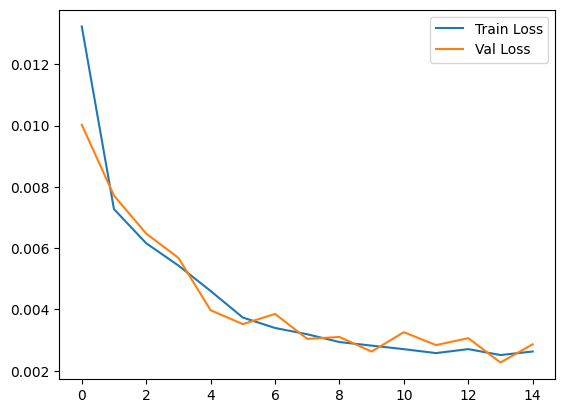

In [11]:
plt.plot(history["train_losses"], label="Train Loss")
plt.plot(history["val_losses"], label="Val Loss")
plt.legend()
plt.show()

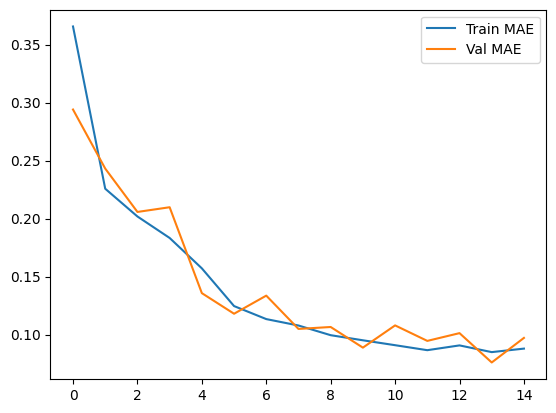

In [12]:
plt.plot(history["train_maes"], label="Train MAE")
plt.plot(history["val_maes"], label="Val MAE")
plt.legend()
plt.show()

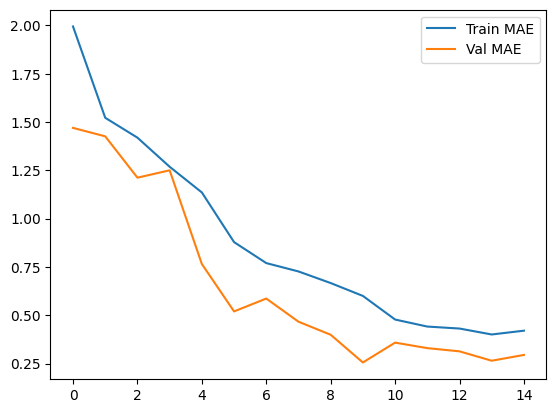

In [13]:
plt.plot(history["train_mapes"], label="Train MAE")
plt.plot(history["val_mapes"], label="Val MAE")
plt.legend()
plt.show()

In [14]:
y_true, y_pred = evaluate_model(model, test_loader, device)
results = compute_forecast_metrics(y_true, y_pred)
results

,horizon,MAE,MAPE
0,1,0.058223,0.092573
1,2,0.062232,0.116754
2,3,0.067055,0.123689
3,4,0.080394,0.139306
4,5,0.093986,0.149630
5,6,0.106969,0.170066
6,7,0.119480,0.193657
7,8,0.131734,0.217270
8,9,0.143838,0.232627
9,10,0.155889,0.247401


In [15]:
y_true_inv = inverse_transform(y_true, scalers['load']['scaler'], scalers['load'].get('lambda'))
y_pred_inv = inverse_transform(y_pred, scalers['load']['scaler'], scalers['load'].get('lambda'))
metrics_df = compute_forecast_metrics(y_true_inv, y_pred_inv)
metrics_df

,horizon,MAE,MAPE
0,1,488.942884,0.005318
1,2,523.580156,0.005856
2,3,564.493457,0.006370
3,4,676.332147,0.007547
4,5,790.385861,0.008760
5,6,899.458514,0.009939
6,7,1004.671774,0.011094
7,8,1107.804536,0.012240
8,9,1209.758234,0.013386
9,10,1311.341711,0.014540


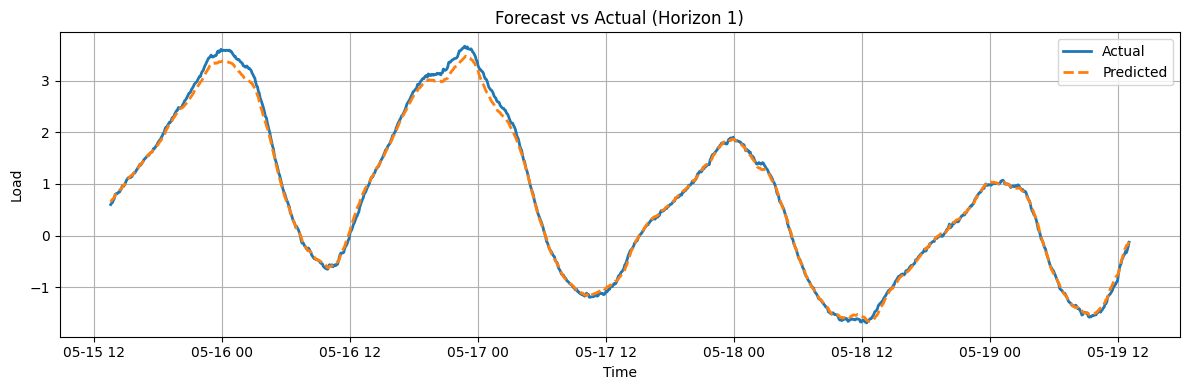

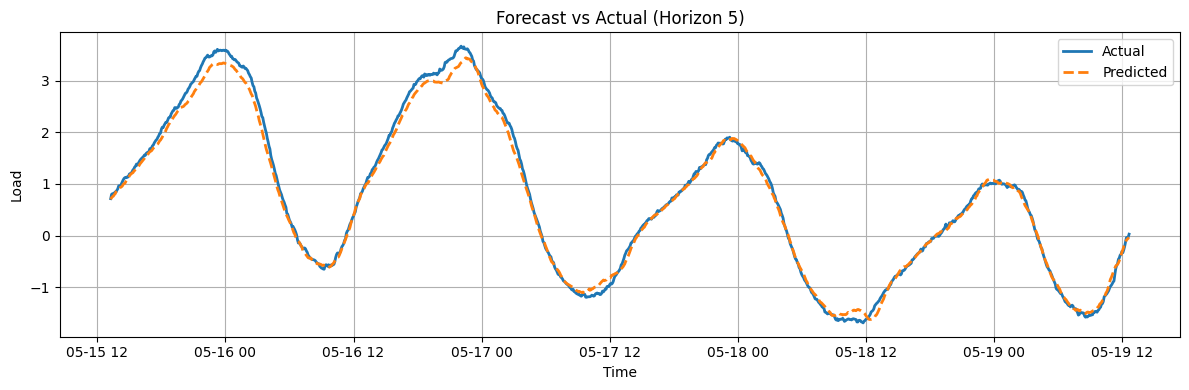

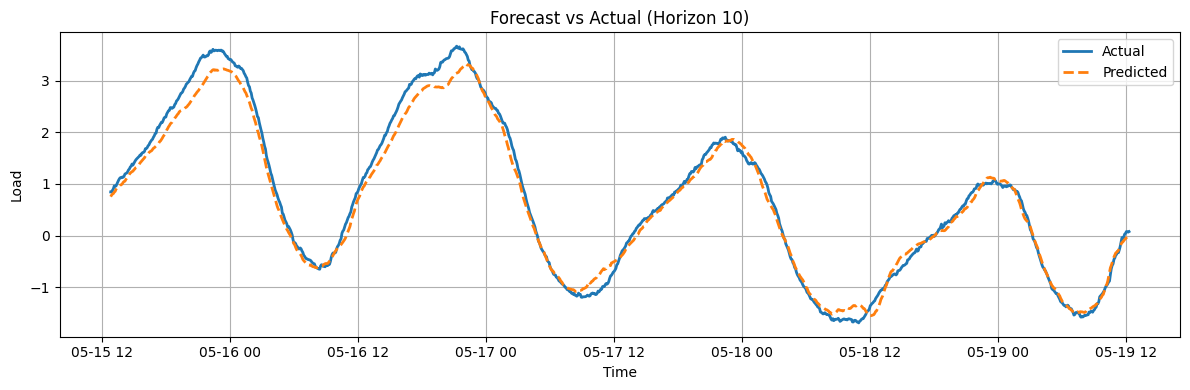

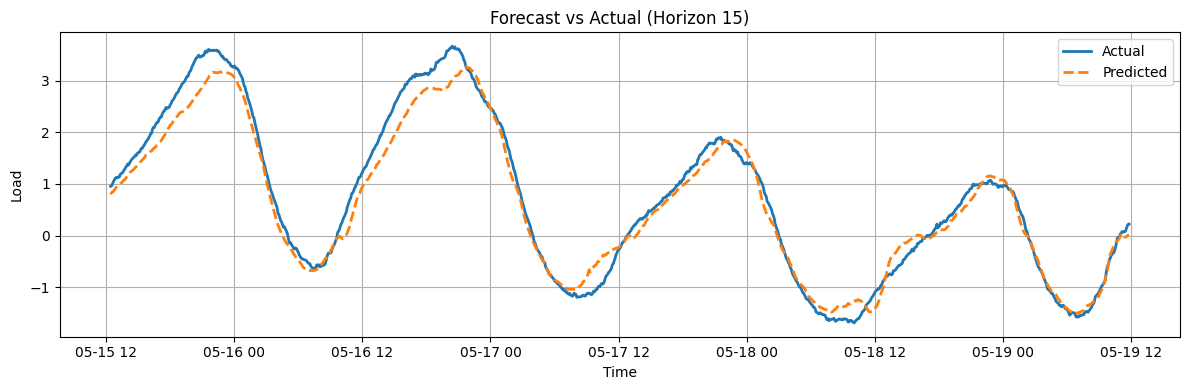

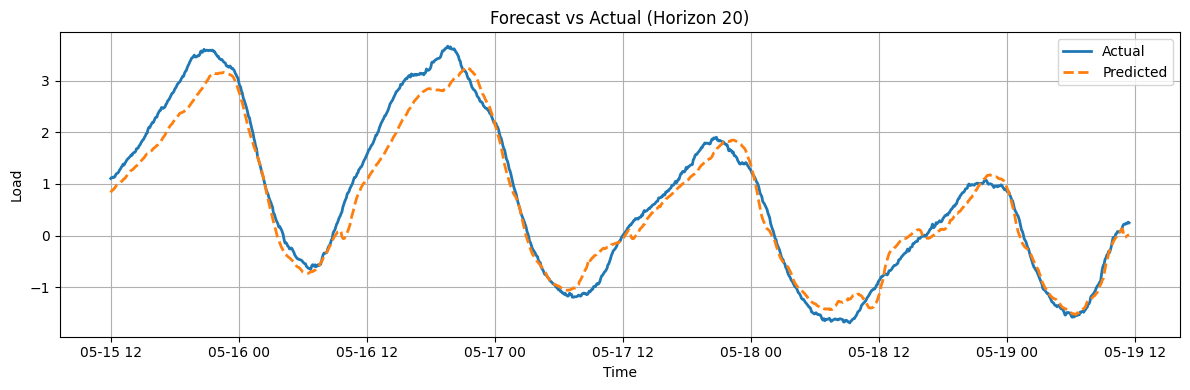

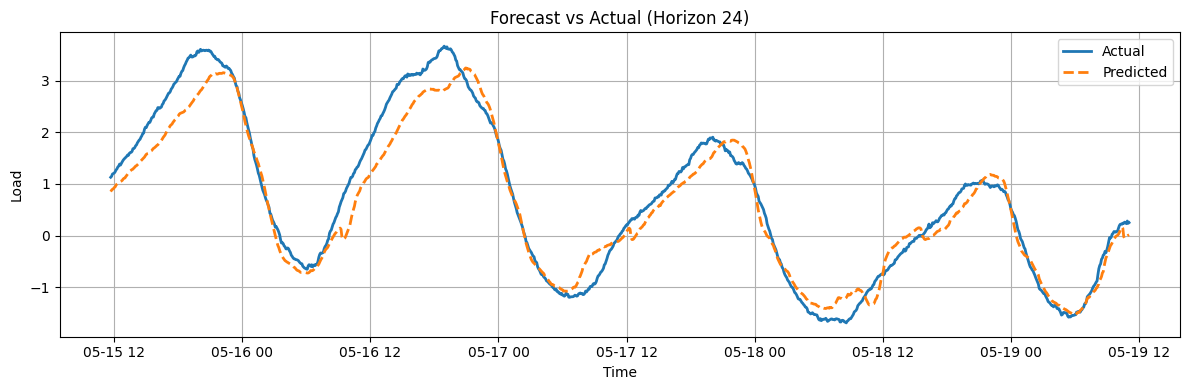

In [20]:
plot_test_vs_pred_time(test_df, y_true, y_pred, horizons=[1, 5, 10, 15, 20, 24])

In [17]:
torch.save(model.state_dict(), "../../deploy/artifacts/model.pt")

In [18]:
import pickle
with open("../../deploy/artifacts/scalers.pkl", "wb") as f:
    pickle.dump(scalers, f)